# Analysis of "Welfare"


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.startswith('all_apps_wide') and file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-08-main_sample'
data = load_csv_files(subfolder_name)


# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)

# Restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = []
if session_codes:
    data = restrict_to_sessions(data, session_codes)

data.columns = data.columns.str.replace('participant.', '')

notebook_path = os.path.dirname(os.path.abspath('__file__'))
data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

files = os.listdir(data_folder_path)
for file in files:
    if file.startswith('prolific_export') and file.endswith('.csv'):
        file_path = os.path.join(data_folder_path, file)
        demographics = pd.read_csv(file_path)

demographics.rename(columns={'Participant id':'label'}, inplace=True)
data = data.merge(demographics, how='outer',on='label')

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create new columns based on conditions
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))
data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x in ['End','Finished'])

# Calculate completion rate
finished_experiment_count = data['finished_experiment'].sum()
started_experiment_count = data['started_experiment'].sum()
completion_rate = finished_experiment_count / started_experiment_count

print('Completion rate:', completion_rate)
print('Number of participants', finished_experiment_count)

Completion rate: 0.9603638726445743
Number of participants 1478


Participants who confirmed their answers the first time: 0.9248985115020297


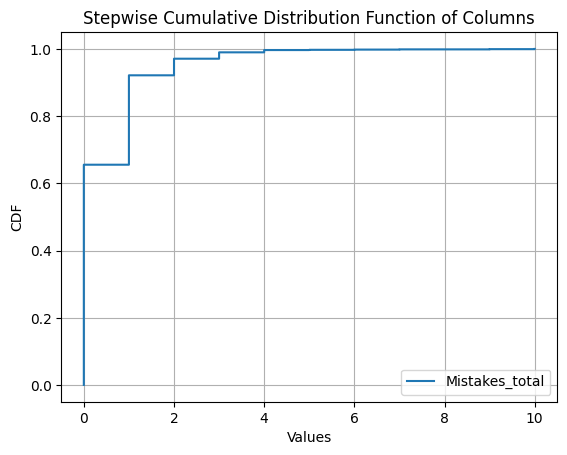

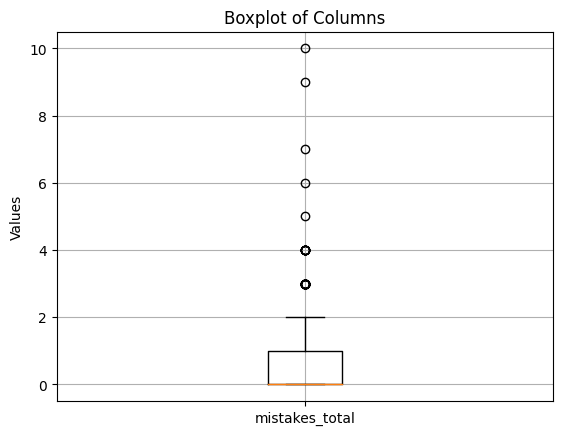

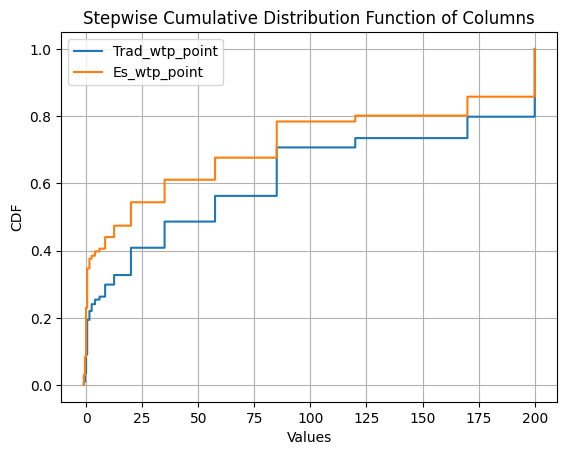

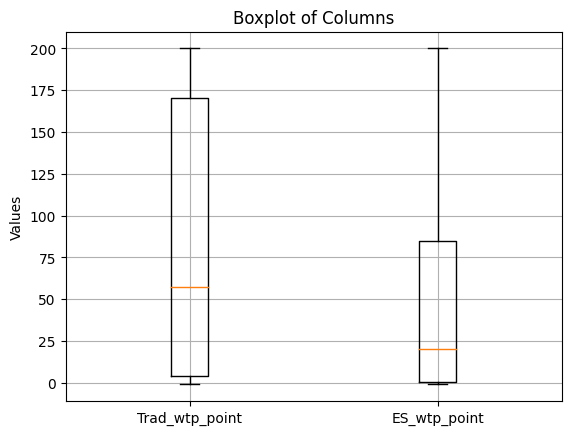

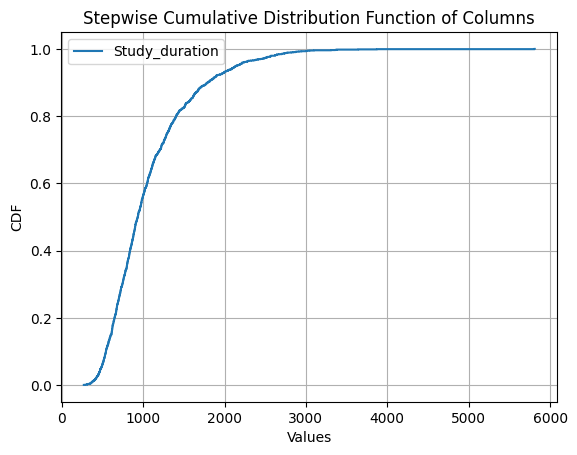

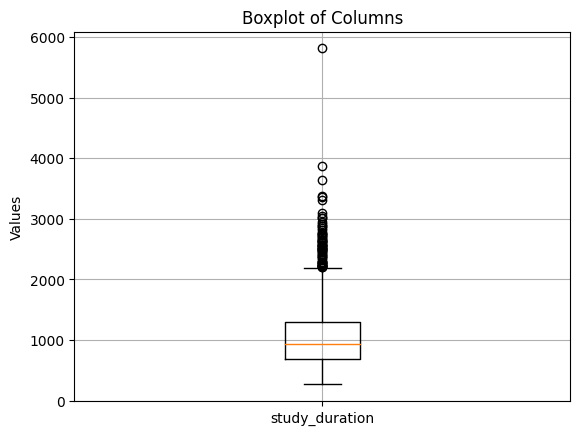

Treatment: low


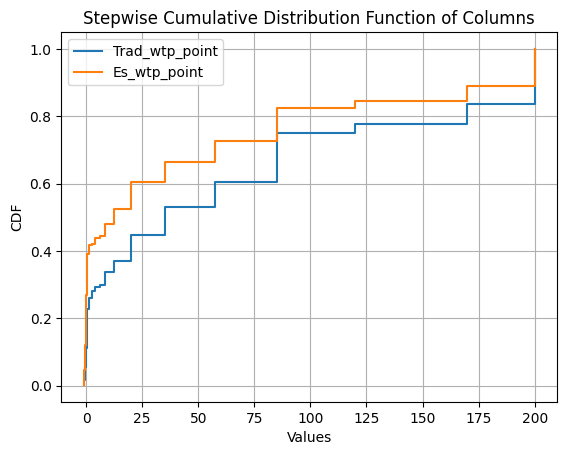

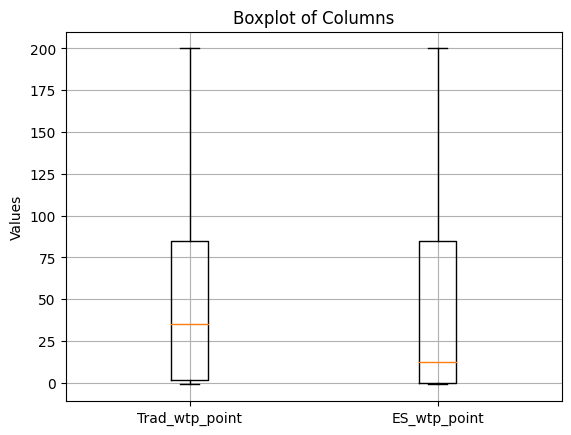

Treatment: middle


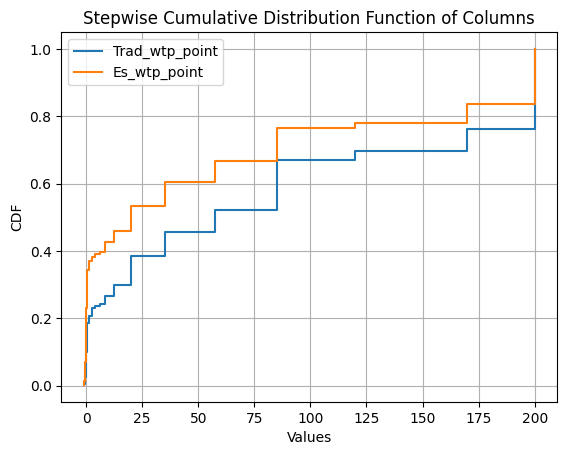

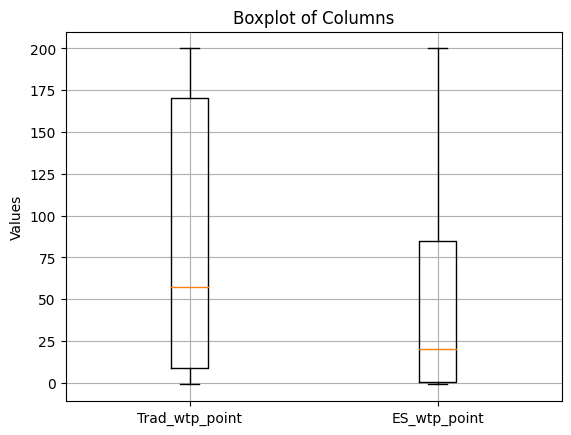

Treatment: high


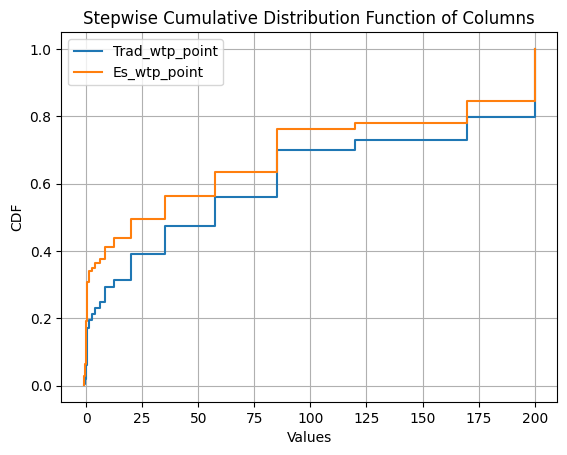

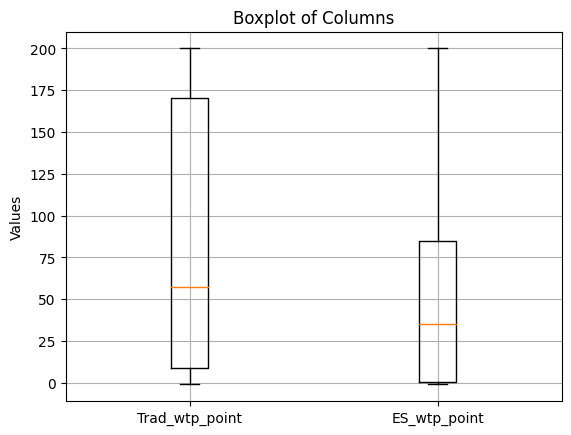

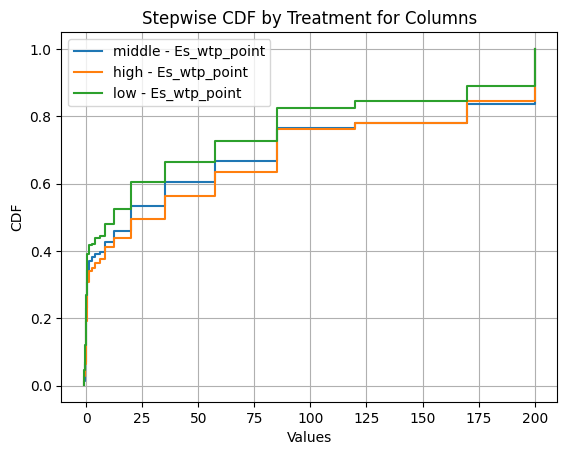

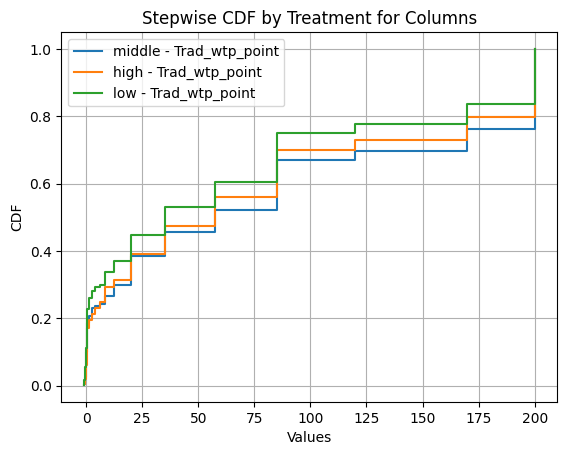

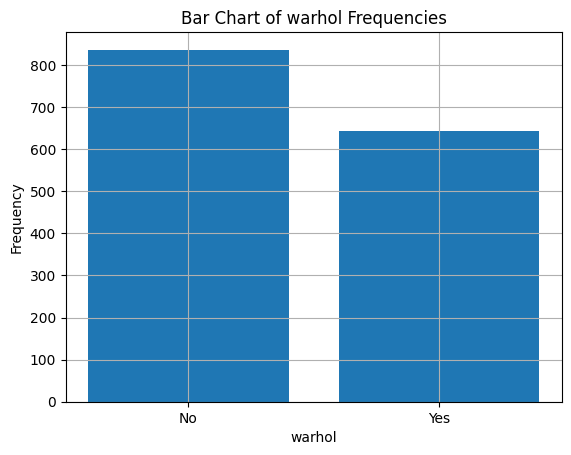

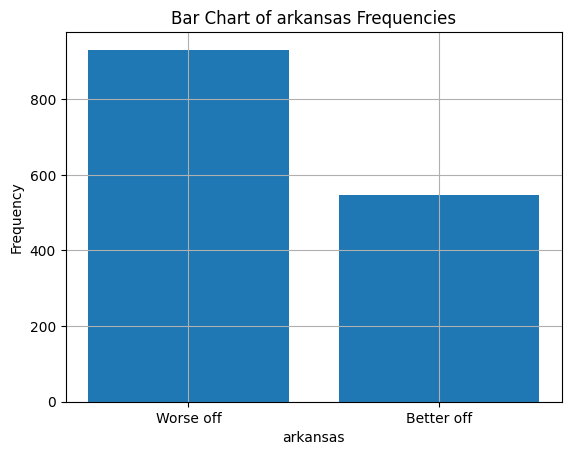

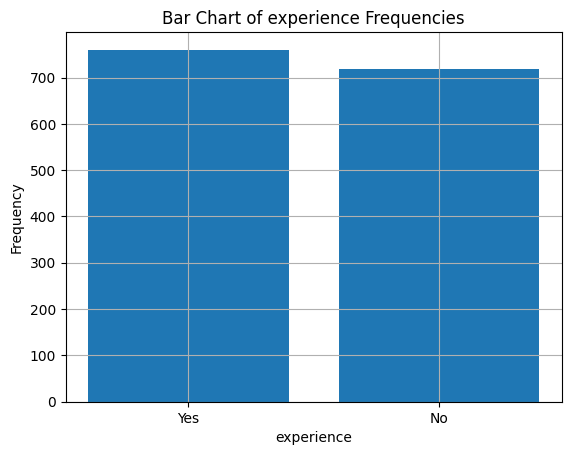

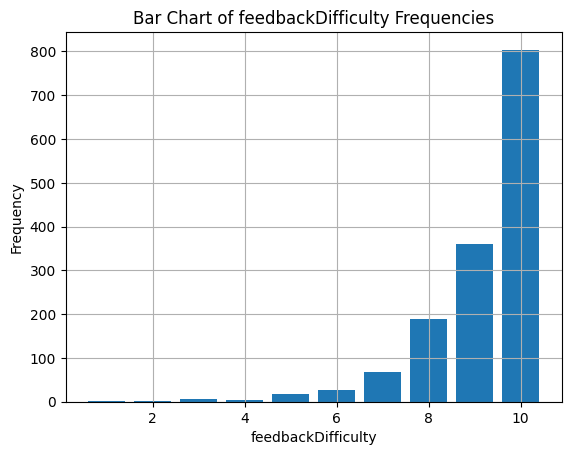

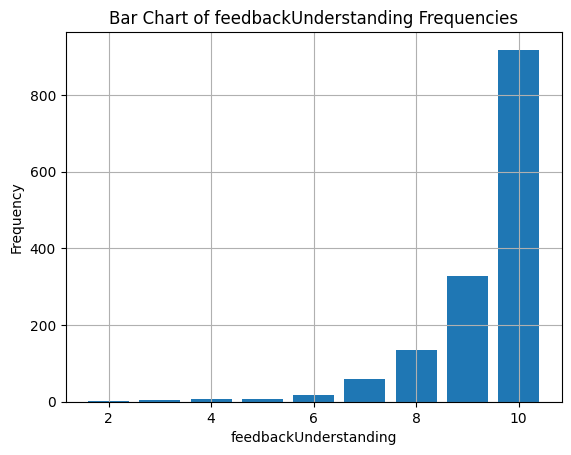

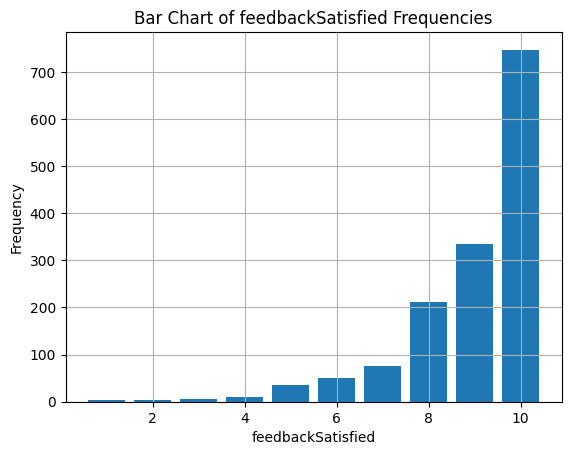

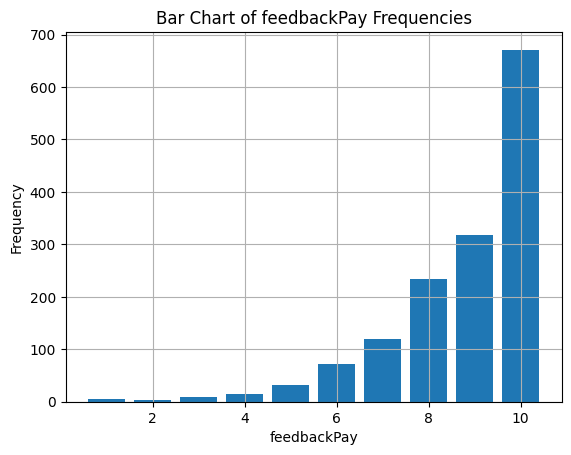

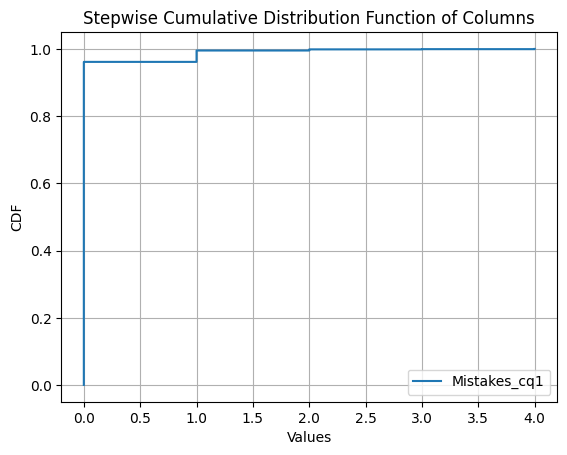

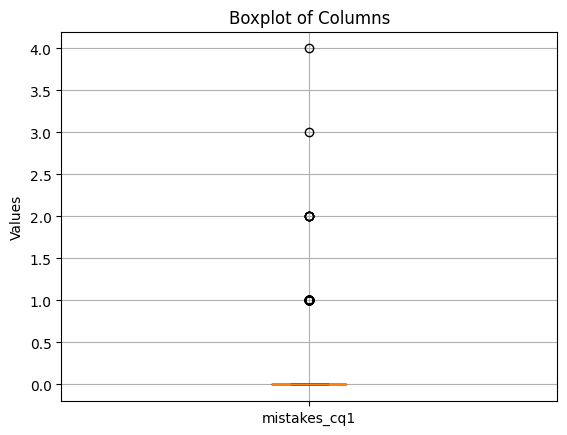

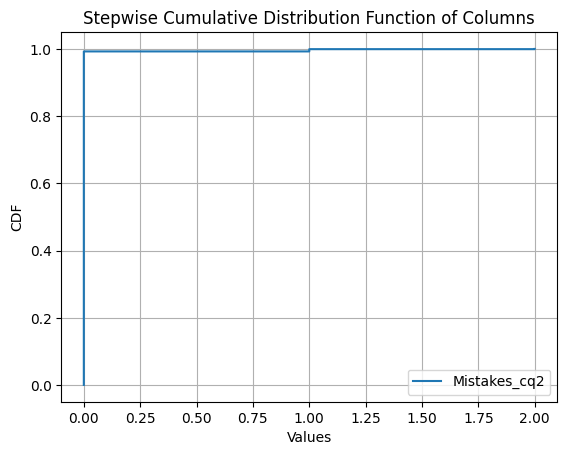

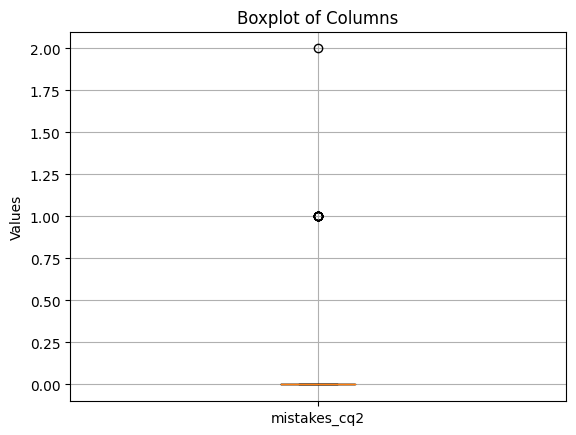

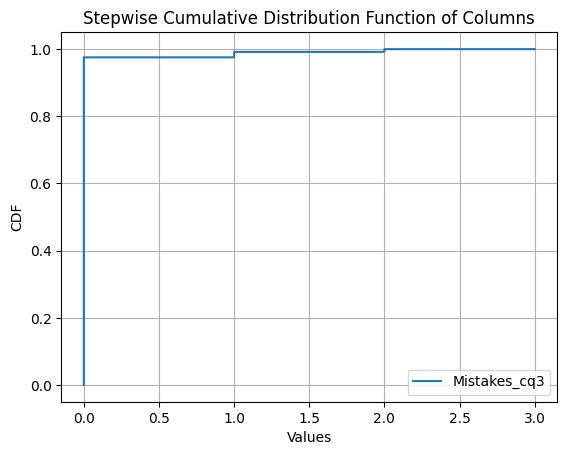

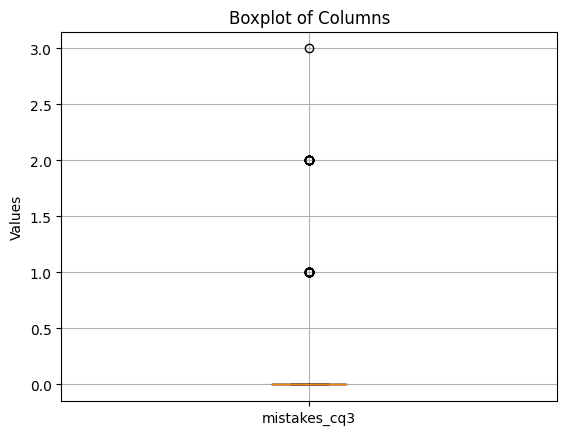

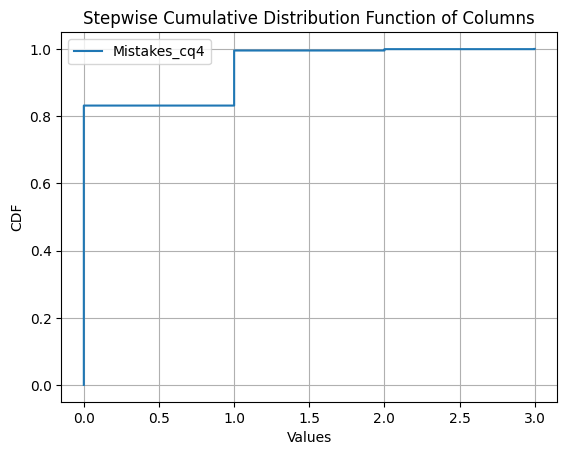

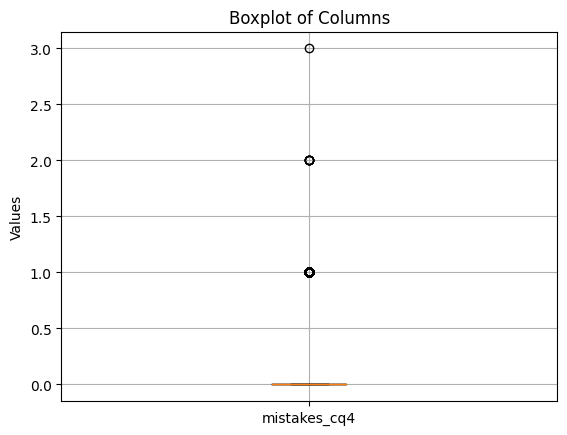

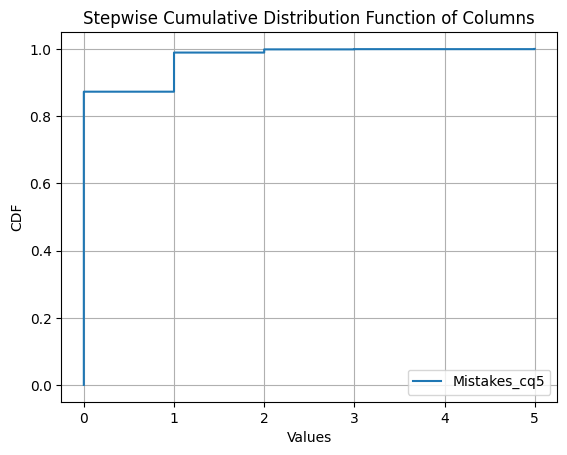

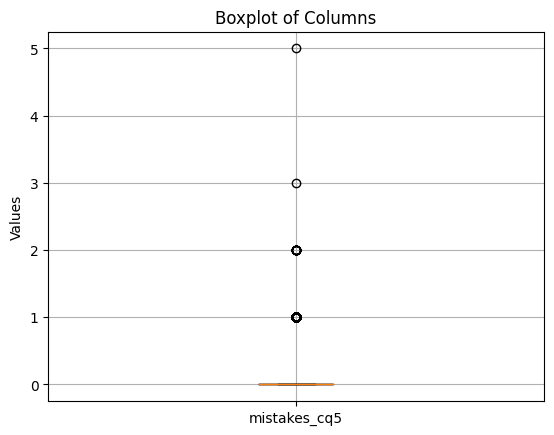

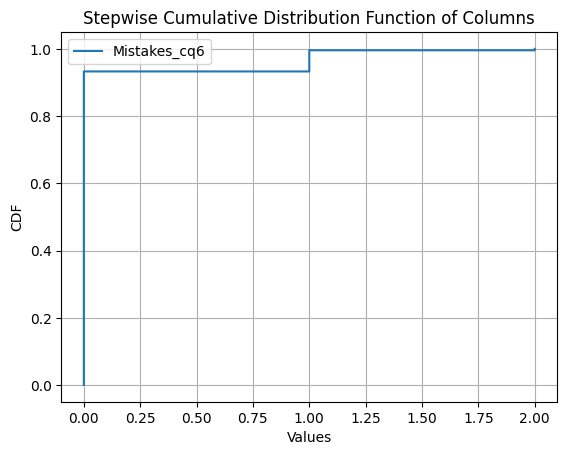

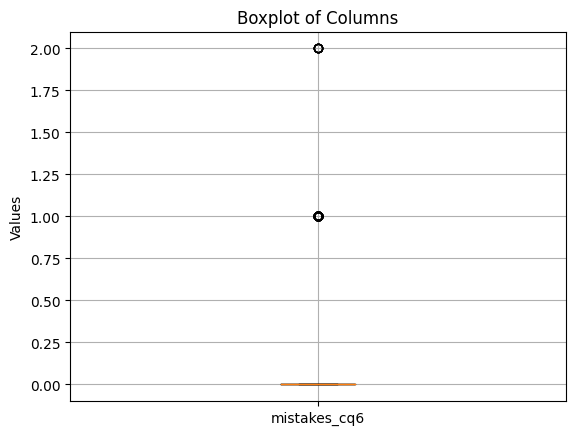

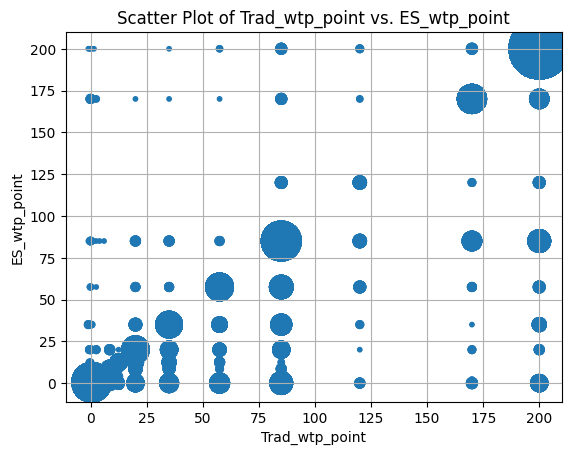

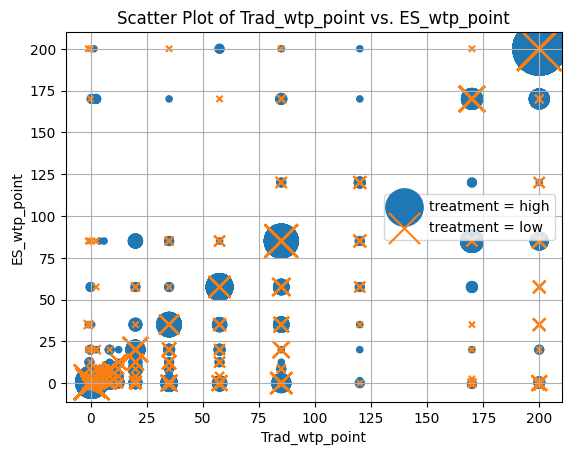

In [74]:
# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment']]

# Rename columns
data['mistakes_cq6'] = data['welfare.1.player.cq6_ambiguous_mistakes']+ data['welfare.1.player.cq6_treatments_mistakes']
data.rename(columns={'welfare.1.player.'+cq+'_mistakes': 'mistakes_'+cq for cq in ['cq1','cq2','cq3','cq4','cq5']}, inplace=True)
data['mistakes_total'] = data[['mistakes_cq1', 'mistakes_cq2', 'mistakes_cq3', 'mistakes_cq4', 'mistakes_cq5', 'mistakes_cq6']].sum(axis=1)

# Calculate share of entries where 'welfare.1.player.confirm' equals 1
total_entries = len(data)
count_equal_1 = data['welfare.1.player.confirm'].eq(1).sum()
share_equal_1 = count_equal_1 / total_entries

print('Participants who confirmed their answers the first time:', share_equal_1)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment']]

# Functions to calculate values based on 'welfare.1.player.confirm'
def calculate_wtp(row, column_suffix):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.{column_suffix}"]

for el in ['ES', 'Trad']:
    data[f'{el}_wtp'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp'), axis=1)
    data[f'{el}_wtp2'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp2'), axis=1)
    data[f'{el}_wtp3'] = data.apply(lambda row: calculate_wtp(row, f'{el}_wtp3'), axis=1)


data['original_first'] = data['choices_orders'].isin([1,3,6])

# Function to get WTP bounds
for el in ['ES', 'Trad']:
    def get_wtp_bound(row): 
        wtp3 = row[f'{el}_wtp3']
        if wtp3 is None or pd.isna(wtp3):
            return "WTP is None"
        cutoff = json.loads(wtp3)['cutoff']
        parts = cutoff.split(":")
        side = parts[0]
        row_choice = int(parts[1])

        if row['original_first']==False:
            side = {'left':'right','right':'left'}[side]

        if side == "right":
            row_choice = row_choice - 1
            side = "left"

        WTP_VALUES = [1, 2, 3, 5, 7, 10, 15, 25, 45, 70, 100, 140, 200, float('inf')]

        WTP_bound = (WTP_VALUES[row_choice + 1], WTP_VALUES[row_choice + 2])
        return WTP_bound
    
    data[f'{el}_wtp3_bounds'] = data.apply(get_wtp_bound,axis=1)

# Function to modify column1
def modify_column1(entry, col2_value, col3_value):
    if col2_value == 3:
        return (0, 0)
    elif col2_value == 2:
        if col3_value == 1:
            return (-1, 0)
        elif col3_value == 2:
            return (-float('inf'), -1)
    elif col2_value == 1:
        if col3_value == 2:
            return (0, 1)
        else: 
            return entry

# Function to calculate average
def calculate_average(tup):
    if np.inf in tup or -np.inf in tup:
        return tup[1]  if tup[0] in [-np.inf,np.inf] else tup[0] 
    return (tup[0] + tup[1]) / 2

# Apply the function to modify 'Column1'
for el in ['ES', 'Trad']:
    data[f'{el}_wtp3_bounds'] = data.apply(lambda row: modify_column1(row[f'{el}_wtp3_bounds'], row[f'{el}_wtp'], row[f'{el}_wtp2']), axis=1)
    data[f'{el}_wtp_point'] = data[f'{el}_wtp3_bounds'].apply(calculate_average)

# Calculate the time difference and create a new column 'study_duration'
data['study_duration'] = data['end_time'] - data['start_time']

# Rename certain columns
data.rename(columns={'welfare.2.player.'+el: el for el in ['warhol','arkansas','experience'] + ['feedback'] + ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']+ ['MPLWhy'] + ['warholWhy','arkansasWhy','experienceWhy']}, inplace=True)

# Replace certain values
data['experience'] = data['experience'].replace({1.0: 'Yes', 0.0: 'No'})
data['warhol'] = data['warhol'].replace({1.0: 'Yes', 0.0: 'No'})
data['arkansas'] = data['arkansas'].replace({1.0: 'Better off', 0.0: 'Worse off'})

# Create output folders if they don't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

data['share_ES'] = data['ES_wtp_point'] / data['Trad_wtp_point']

cond1 = data['ES_wtp_point'] == data['Trad_wtp_point']
data['pure_ES'] = cond1

cond1 = data['ES_wtp_point'] == 0
data['pure_MS'] = cond1



# Functions to plot and save CDF, boxplot, and bar chart
def plot_and_save_cdf(data, column_names, filename):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Loop through the list of column names
    for column_name in column_names:
        # Calculate and plot the stepwise CDF
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post', label=column_name.capitalize())

    # Add labels and title
    ax.set_xlabel('Values')
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of Columns')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_{filename}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


def plot_and_save_cdf_by_treatment(data, column_names, treatment_column, filename):
    # Get unique treatment values
    unique_treatments = data[treatment_column].unique()

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Loop through the list of column names
    for column_name in column_names:
        # Loop through unique treatments and plot separate CDF for each
        for treatment in unique_treatments:
            treatment_data = data[data[treatment_column] == treatment]
            sorted_data = np.sort(treatment_data[column_name])
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=f'{treatment} - {column_name.capitalize()}')

    # Add labels and title
    ax.set_xlabel('Values')
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise CDF by Treatment for Columns')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf_by_treatment_{filename}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


def plot_and_save_boxplot(data, column_names, filename):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Data for boxplot
    data_to_plot = [data[column_name] for column_name in column_names]

    # Create the boxplot
    ax.boxplot(data_to_plot, labels=column_names)

    # Add labels and title
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot of Columns')

    # Show the plot
    ax.grid(True)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot_{filename}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_bar_chart(data, column_name, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Data for bar chart
    value_counts = data[column_name].value_counts()

    # Create the bar chart with frequencies as heights and unique values as x-axis labels
    ax.bar(value_counts.index, value_counts)

    # Add labels and title
    ax.set_xlabel(column_name)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Bar Chart of {column_name} Frequencies')

    # Show the plot
    ax.grid(True)

    # Save the bar chart in the subfolder
    file_path = os.path.join(subfolder_path, f'bar_chart_{column_name}_frequencies.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

def plot_and_save_scatter(data, x_column, y_column, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Get the counts of each unique pair of (x, y) coordinates
    counts = data.groupby([x_column, y_column]).size().reset_index(name='count')

    # Merge counts back with the original data to match (x, y) coordinates
    merged_data = data.merge(counts, on=[x_column, y_column])

    # Scatter plot with increased size for dots with multiple occurrences
    ax.scatter(merged_data[x_column], merged_data[y_column], s=merged_data['count'] * 10)  # You can adjust the multiplier (10 in this case) as needed

    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'Scatter Plot of {x_column} vs. {y_column}')

    # Show the plot
    ax.grid(True)

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the scatter plot in the subfolder
    file_path = os.path.join(subfolder_path, f'scatter_plot_{x_column}_vs_{y_column}.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


def plot_and_save_scatter_with_condition(data, x_column, y_column, condition_column, condition_x, condition_y, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Separate the data based on the condition_column
    data_x = data[data[condition_column] == condition_x]
    data_y = data[data[condition_column] == condition_y]

    # Get the counts of each unique pair of (x, y) coordinates for both conditions
    counts_x = data_x.groupby([x_column, y_column]).size().reset_index(name='count')
    counts_y = data_y.groupby([x_column, y_column]).size().reset_index(name='count')

    # Merge counts back with the original data to match (x, y) coordinates
    data_x = data_x.merge(counts_x, on=[x_column, y_column])
    data_y = data_y.merge(counts_y, on=[x_column, y_column])

    # Scatter plot for condition_x points with increased size for dots with multiple occurrences
    ax.scatter(data_x[x_column], data_x[y_column], label=f'{condition_column} = {condition_x}', marker='o', s=data_x['count'] * 20)

    # Scatter plot for condition_y points with increased size for dots with multiple occurrences
    ax.scatter(data_y[x_column], data_y[y_column], label=f'{condition_column} = {condition_y}', marker='x', s=data_y['count'] * 20)

    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'Scatter Plot of {x_column} vs. {y_column}')

    # Show the plot
    ax.grid(True)
    ax.legend()

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the scatter plot in the subfolder
    file_path = os.path.join(subfolder_path, f'scatter_plot_{x_column}_vs_{y_column}_with_condition.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


# Call the functions to plot and save the desired graphs
plot_and_save_cdf(data, ['mistakes_total'], 'mistakes_total')
plot_and_save_boxplot(data, ['mistakes_total'], 'mistakes_total')
plot_and_save_cdf(data, ['Trad_wtp_point','ES_wtp_point'], 'wtp_point')
plot_and_save_boxplot(data, ['Trad_wtp_point','ES_wtp_point'], 'wtp_point')
plot_and_save_cdf(data,['study_duration'], 'study_duration')
plot_and_save_boxplot(data, ['study_duration'], 'study_duration')

for el in ['low','middle','high']:
    select_data = data[data['treatment']==el]
    print('Treatment:', el)
    plot_and_save_cdf(select_data, ['Trad_wtp_point','ES_wtp_point'], f'wtp_point_{el}')
    plot_and_save_boxplot(select_data, ['Trad_wtp_point','ES_wtp_point'], f'wtp_point_{el}') 
    
plot_and_save_cdf_by_treatment(data, ['ES_wtp_point'], 'treatment', 'ES_wtp_point_by_treatment')
plot_and_save_cdf_by_treatment(data, ['Trad_wtp_point'], 'treatment', 'Trad_wtp_point_by_treatment')

for el in ['warhol','arkansas','experience']:
    plot_and_save_bar_chart(data, el, subfolder_name)

for el in ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']:
    plot_and_save_bar_chart(data, el, subfolder_name)

for question in ['mistakes_cq1', 'mistakes_cq2', 'mistakes_cq3', 'mistakes_cq4','mistakes_cq5', 'mistakes_cq6']:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, [question], subfolder_name)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, [question], subfolder_name)

plot_and_save_scatter(data, 'Trad_wtp_point', 'ES_wtp_point', subfolder_name)
plot_and_save_scatter_with_condition(data, 'Trad_wtp_point', 'ES_wtp_point', 'treatment', 'high', 'low', subfolder_name)


# Select only the desired columns
selected_columns = ['label'] + ['warhol','arkansas','experience'] + ['warholWhy','arkansasWhy','experienceWhy']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'open_ended.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
selected_columns = ['label'] +  ['feedback'] + ['feedbackDifficulty', 'feedbackUnderstanding', 'feedbackSatisfied', 'feedbackPay']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)

# Select only the desired columns
cond1 = data['ES_wtp_point'] >= 0 
cond2 = data['Trad_wtp_point'] > 0

data['wtp_ratio'] = data['ES_wtp_point'] / data['Trad_wtp_point']

data['Reasonable'] = cond1 & cond2

data['study_duration_minutes'] = data['study_duration'] / 60
data['study_duration_minutes'] = data['study_duration_minutes'].round(1)
selected_columns = ['label'] + ['Trad_wtp3_bounds','ES_wtp3_bounds'] + ['Reasonable'] + ['treatment'] + ['mistakes_total']+ ['study_duration_minutes'] + ['MPLWhy']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'MPLWhy.csv')
selected_data.to_csv(file_path, index=False)

In [44]:

def calculate_wtp_metrics(data):
    output = {}
    for wtp_type in ['ES', 'Trad']:
        cond1 = data[f'{wtp_type}_wtp_point'] <= 0.5
        cond2 = data[f'{wtp_type}_wtp_point'] >= -0.5

        data[f'{wtp_type}_wtp_zero'] = cond1 & cond2

        cond1 = data[f'{wtp_type}_wtp_point'] > 0.5
        data[f'{wtp_type}_wtp_strict_pos'] = cond1

        cond1 = data[f'{wtp_type}_wtp_point'] < -0.5
        data[f'{wtp_type}_wtp_strict_neg'] = cond1

    data['ES_less_than_Trad_and_pos'] = (data['Trad_wtp_point'] > data['ES_wtp_point']) & (data['ES_wtp_point'] > 0)
    data['ES_less_than_Trad_and_neg'] = (data['Trad_wtp_point'] > data['ES_wtp_point']) & (data['ES_wtp_point'] < 0)
    data['ES_equal_0'] = data['ES_wtp_point'] == 0
    data['ES_equal_Trad'] = data['Trad_wtp_point'] == data['ES_wtp_point']
    data['ES_greater_than_Trad'] = data['Trad_wtp_point'] < data['ES_wtp_point']

    myNumber = 0
    for WTP_type in ['strict_neg', 'zero']:
        for ES_type in ['strict_neg', 'zero', 'strict_pos']:

            data['Trad_wtp_' + WTP_type +'_ES_wtp_'+ES_type] = data[f'Trad_wtp_{WTP_type}'] & data[f'ES_wtp_{ES_type}']
            x = round(100* (sum(data['Trad_wtp_' + WTP_type +'_ES_wtp_'+ES_type])/len(data)) ,2)
            # x = round(100 * sum(data[f'Trad_wtp_{WTP_type}'] & data[f'ES_wtp_{ES_type}']) / len(data), 2)
            myNumber += x
            print(f'WTP {WTP_type} and ES {ES_type}: ', x)
            output[f'WTP {WTP_type} and ES {ES_type}'] = x
    partial = 0
    for ES_type in ['less_than_Trad_and_pos', 'less_than_Trad_and_neg', 'equal_0', 'equal_Trad', 'greater_than_Trad']:
        data['Trad_wtp_strict_pos_ES_wtp_'+ES_type] = data[f'Trad_wtp_strict_pos'] & data[f'ES_{ES_type}']

        x = round(100* (sum(data['Trad_wtp_strict_pos_ES_wtp_'+ES_type])/len(data)) ,2)

        # x = round(100 * sum(data[f'Trad_wtp_strict_pos'] & data[f'ES_{ES_type}']) / len(data), 2)
        print(f'WTP strict_pos and ES {ES_type}: ', x)
        myNumber += x
        partial += x
        output[f'WTP strict_pos and ES {ES_type}'] = x
    print('WTP strict_pos = ', partial)
    print(myNumber)
    return data, output 


data, _ = calculate_wtp_metrics(data)

for treatment in ['middle','high','low']:
    print(treatment)
    calculate_wtp_metrics(data[data['treatment']==treatment])
print(len(data[data['treatment']==treatment]))




WTP strict_neg and ES strict_neg:  0.41
WTP strict_neg and ES zero:  0.07
WTP strict_neg and ES strict_pos:  0.54
WTP zero and ES strict_neg:  0.47
WTP zero and ES zero:  15.02
WTP zero and ES strict_pos:  2.91
WTP strict_pos and ES less_than_Trad_and_pos:  27.0
WTP strict_pos and ES less_than_Trad_and_neg:  4.87
WTP strict_pos and ES equal_0:  8.73
WTP strict_pos and ES equal_Trad:  33.83
WTP strict_pos and ES greater_than_Trad:  6.16
WTP strict_pos =  80.59
100.00999999999999
middle
WTP strict_neg and ES strict_neg:  0.2
WTP strict_neg and ES zero:  0.2
WTP strict_neg and ES strict_pos:  0.2
WTP zero and ES strict_neg:  0.41
WTP zero and ES zero:  14.4
WTP zero and ES strict_pos:  3.04
WTP strict_pos and ES less_than_Trad_and_pos:  29.01
WTP strict_pos and ES less_than_Trad_and_neg:  3.65
WTP strict_pos and ES equal_0:  10.14
WTP strict_pos and ES equal_Trad:  33.67
WTP strict_pos and ES greater_than_Trad:  5.07
WTP strict_pos =  81.53999999999999
99.99000000000001
high
WTP strict_ne

/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{wtp_type}_wtp_zero'] = cond1 & cond2
/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{wtp_type}_wtp_strict_pos'] = cond1
/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 396 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 396 0
41
262
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.6616161616161617 396 262
48
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.12121212121212122 396 48
[0.0, 0.0, 0.0, 0.0, 0.10353535353535354, 0.6616161616161617, 0.12121212121212122] here
0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 354 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 354 0
24
238
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.672316384180791 354 238
43
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.12146892655367232 354 43
[0.0, 0.0, 0.0, 0.0, 0.06779661016949153, 0.672316384180791, 0.12146892655367232] here


/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/56268697.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['<','0','0--1/3','1/3--2/3','2/3--1','1','>1'], rotation=45)


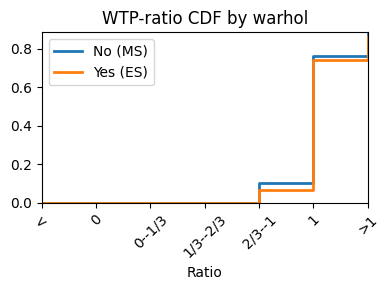

0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 485 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 485 0
40
321
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.6618556701030928 485 321
57
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.11752577319587629 485 57
[0.0, 0.0, 0.0, 0.0, 0.08247422680412371, 0.6618556701030928, 0.11752577319587629] here
0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 265 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 265 0
25
179
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.6754716981132075 265 179
34
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.12830188679245283 265 34
[0.0, 0.0, 0.0, 0.0, 0.09433962264150944, 0.6754716981132075, 0.12830188679245283] here


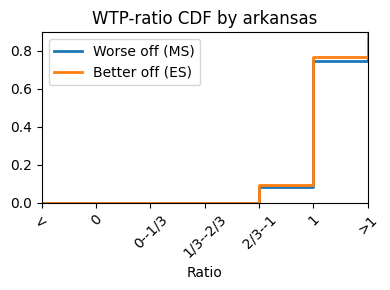

0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 373 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 373 0
30
242
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.6487935656836461 373 242
44
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.11796246648793565 373 44
[0.0, 0.0, 0.0, 0.0, 0.08042895442359249, 0.6487935656836461, 0.11796246648793565] here
0
Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg
0.0 377 0
0
Trad_wtp_strict_pos_ES_wtp_equal_0
0.0 377 0
35
258
Trad_wtp_strict_pos_ES_wtp_equal_Trad
0.6843501326259946 377 258
47
Trad_wtp_strict_pos_ES_wtp_greater_than_Trad
0.1246684350132626 377 47
[0.0, 0.0, 0.0, 0.0, 0.09283819628647215, 0.6843501326259946, 0.1246684350132626] here


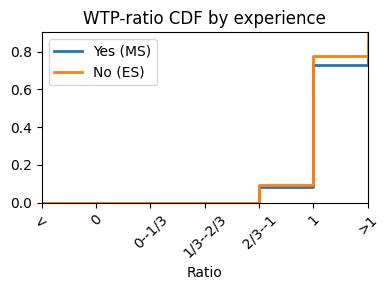

In [121]:

cutoffs = [1/3,2/3,1]

ES_types = ['less_than_Trad_and_neg','equal_0','less_than_Trad_and_pos',  'equal_Trad', 'greater_than_Trad']




labels_unincentivized = {
    'warhol': [('No', 'No (MS)'), ('Yes', 'Yes (ES)')],
    'arkansas': [('Worse off', 'Worse off (MS)'), ('Better off', 'Better off (ES)')],
    'experience': [('Yes', 'Yes (MS)'), ('No', 'No (ES)')],
}


def plot_and_save_cdf_by_unincentivized_answer(data, question, filename):

    # Get unique treatment values
    answers = labels_unincentivized[question]
    
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4,3))
    
    # Loop through unique treatments and plot separate CDF for each
    for answer in answers:

        treatment_data = data[data[question] == answer[0]]


        myList = []

        for ES_type in ES_types:
            print(sum(treatment_data['Trad_wtp_strict_pos_ES_wtp_'+ES_type]))
            if ES_type == 'less_than_Trad_and_pos':
                y = 0
                for cutoff in cutoffs:
                    cond1 =  treatment_data['wtp_ratio'] < cutoff
                    cond2 = treatment_data['wtp_ratio'] >= y 
                    x = sum(treatment_data['Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_pos'] & cond1 & cond2)/len(treatment_data)
                    y = cutoff
                    myList.append(x)
            else:
                name = 'Trad_wtp_strict_pos_ES_wtp_'+ES_type
                print(name)
                x = sum(treatment_data[name])/len(treatment_data)  
                print(x,len(treatment_data),sum(treatment_data[name]))
                myList.append(x)

        print(myList,'here')
        cumulative_sum = np.cumsum(myList)
        linestyle = '-'
        linewidth = 2
        # print(cumulative_sum)
        label=answer[1]
        ax.step(range(len(cumulative_sum)),cumulative_sum, where='post', label=label, linestyle=linestyle, linewidth=linewidth)

        ax.set_xticklabels(['<','0','0--1/3','1/3--2/3','2/3--1','1','>1'], rotation=45)


        # ax.set_xlim(-1.5, 1.5)
    # Set title based on WTP_type
    # if WTP_type == 'ES':
    #     ax.set_title('ES CDF by treatment')
    # elif WTP_type == 'Trad':
    #     ax.set_title('WTP CDF by treatment')

    ax.set_title(f'WTP-ratio CDF by {question}')

    # Add labels and legend
    ax.set_xlabel('Ratio')
    ax.legend()
    ax.margins(x=0,y=0)

    plt.tight_layout()

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'{filename}.png')
    plt.savefig(file_path)


    # Display the plot (optional)
    plt.show()


cond1 = data['Trad_wtp_point'] > 0
codn2 = data['treatment']=='middle'
for question in labels_unincentivized.keys():
    plot_and_save_cdf_by_unincentivized_answer(data[cond1 & cond2], question, f'wtp-ratio_cdf_{question}')






In [119]:
# sum(data['Trad_wtp_strict_pos_ES_wtp_less_than_Trad'])/len(data)

# test_data = data[data['treatment']=='middle']

# sum(test_data['Trad_wtp_strict_pos_ES_wtp_less_than_Trad'])/len(test_data)


# test_data['Trad_wtp_strict_pos_ES_wtp_'+'less_than_Trad']

sum(data['Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg'])

72

In [61]:
answer_dict = {'warhol': ['Yes','No'], 'arkansas': ['Better off','Worse off'],'experience':['Yes','No'],}


tables = {}






for question in ['warhol','arkansas','experience']:
    for i in range(2):
        
        cond1 = data[question] == answer_dict[question][i]
        cond2 = data['treatment']=='middle'
        _, output = calculate_wtp_metrics(data[cond1 & cond2])


        text = f"{output['WTP strict_neg and ES strict_neg']}\% & {output['WTP strict_neg and ES zero']}\% & {output['WTP strict_neg and ES strict_pos']}\% & {output['WTP zero and ES strict_neg']}\% & {output['WTP zero and ES zero']}\% & {output['WTP zero and ES strict_pos']}\% & {output['WTP strict_pos and ES less_than_Trad_and_neg']}\% & {output['WTP strict_pos and ES equal_0']}\% & {output['WTP strict_pos and ES less_than_Trad_and_pos']}\% & {output['WTP strict_pos and ES equal_Trad']}\% & {output['WTP strict_pos and ES greater_than_Trad']}\%"

        tables[f'{question}_{answer_dict[question][i]}'] = text


print(tables)


WTP strict_neg and ES strict_neg:  0.0
WTP strict_neg and ES zero:  0.0
WTP strict_neg and ES strict_pos:  0.0
WTP zero and ES strict_neg:  0.94
WTP zero and ES zero:  15.49
WTP zero and ES strict_pos:  1.88
WTP strict_pos and ES less_than_Trad_and_pos:  26.29
WTP strict_pos and ES less_than_Trad_and_neg:  3.76
WTP strict_pos and ES equal_0:  7.98
WTP strict_pos and ES equal_Trad:  36.62
WTP strict_pos and ES greater_than_Trad:  7.04
WTP strict_pos =  81.69000000000001
99.99999999999999
WTP strict_neg and ES strict_neg:  0.36
WTP strict_neg and ES zero:  0.36
WTP strict_neg and ES strict_pos:  0.36
WTP zero and ES strict_neg:  0.0
WTP zero and ES zero:  13.57
WTP zero and ES strict_pos:  3.93
WTP strict_pos and ES less_than_Trad_and_pos:  31.07
WTP strict_pos and ES less_than_Trad_and_neg:  3.57
WTP strict_pos and ES equal_0:  11.79
WTP strict_pos and ES equal_Trad:  31.43
WTP strict_pos and ES greater_than_Trad:  3.57
WTP strict_pos =  81.42999999999999
100.00999999999999
WTP strict_n

/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{wtp_type}_wtp_zero'] = cond1 & cond2
/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{wtp_type}_wtp_strict_pos'] = cond1
/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/2449067238.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [62]:
tables

{'warhol_Yes': '0.0\\% & 0.0\\% & 0.0\\% & 0.94\\% & 15.49\\% & 1.88\\% & 3.76\\% & 7.98\\% & 26.29\\% & 36.62\\% & 7.04\\%',
 'warhol_No': '0.36\\% & 0.36\\% & 0.36\\% & 0.0\\% & 13.57\\% & 3.93\\% & 3.57\\% & 11.79\\% & 31.07\\% & 31.43\\% & 3.57\\%',
 'arkansas_Better off': '0.0\\% & 0.0\\% & 0.0\\% & 0.54\\% & 13.98\\% & 2.15\\% & 4.3\\% & 9.14\\% & 31.18\\% & 33.87\\% & 4.84\\%',
 'arkansas_Worse off': '0.33\\% & 0.33\\% & 0.33\\% & 0.33\\% & 14.66\\% & 3.58\\% & 3.26\\% & 10.75\\% & 27.69\\% & 33.55\\% & 5.21\\%',
 'experience_Yes': '0.42\\% & 0.0\\% & 0.42\\% & 0.42\\% & 13.33\\% & 3.33\\% & 4.17\\% & 12.08\\% & 27.5\\% & 34.58\\% & 3.75\\%',
 'experience_No': '0.0\\% & 0.4\\% & 0.0\\% & 0.4\\% & 15.42\\% & 2.77\\% & 3.16\\% & 8.3\\% & 30.43\\% & 32.81\\% & 6.32\\%'}

In [52]:
\\

{'warhol_Yes': '\\parbox[t]{2.5cm}{Baseline\\\x0bspace{1em} \\hspace{1.5em}N=497} &0.16\\% & 0.0\\% & 0.62\\% & 0.93\\% & 17.13\\% & 2.96\\% & 6.54\\% & 6.7\\% & 21.18\\% & 37.07\\% & 6.7\\%',
 'warhol_No': '\\parbox[t]{2.5cm}{Baseline\\\x0bspace{1em} \\hspace{1.5em}N=497} &0.6\\% & 0.12\\% & 0.48\\% & 0.12\\% & 13.4\\% & 2.87\\% & 3.59\\% & 10.29\\% & 31.46\\% & 31.34\\% & 5.74\\%',
 'arkansas_Better off': '\\parbox[t]{2.5cm}{Baseline\\\x0bspace{1em} \\hspace{1.5em}N=497} &0.18\\% & 0.0\\% & 0.73\\% & 0.73\\% & 14.99\\% & 3.11\\% & 6.4\\% & 8.59\\% & 26.33\\% & 32.72\\% & 6.22\\%',
 'arkansas_Worse off': '\\parbox[t]{2.5cm}{Baseline\\\x0bspace{1em} \\hspace{1.5em}N=497} &0.54\\% & 0.11\\% & 0.43\\% & 0.32\\% & 15.04\\% & 2.79\\% & 3.97\\% & 8.81\\% & 27.39\\% & 34.48\\% & 6.12\\%',
 'experience_Yes': '\\parbox[t]{2.5cm}{Baseline\\\x0bspace{1em} \\hspace{1.5em}N=497} &0.26\\% & 0.0\\% & 0.66\\% & 0.53\\% & 16.05\\% & 3.03\\% & 5.26\\% & 9.61\\% & 26.97\\% & 31.84\\% & 5.79\\%',
 'exper

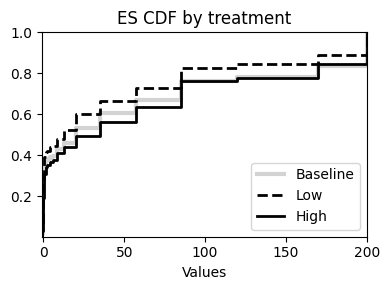

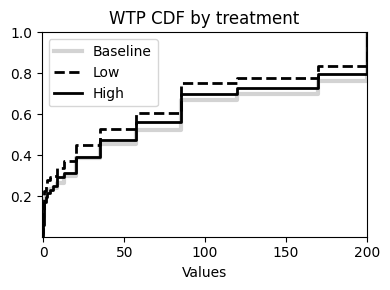

Trad_wtp_strict_neg_ES_wtp_strict_neg ES


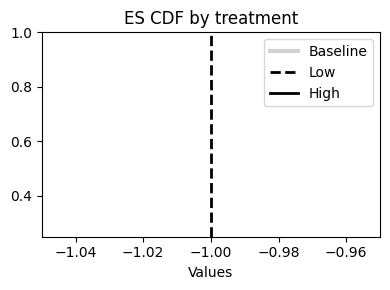

Trad_wtp_strict_neg_ES_wtp_strict_neg Trad


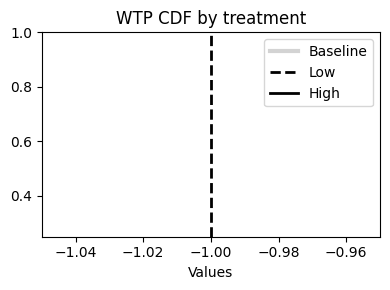

Trad_wtp_strict_neg_ES_wtp_zero ES


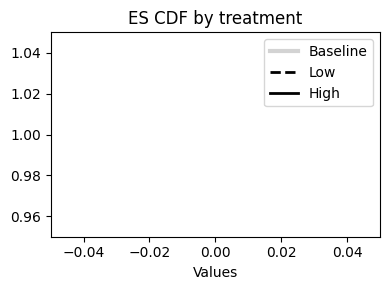

Trad_wtp_strict_neg_ES_wtp_zero Trad


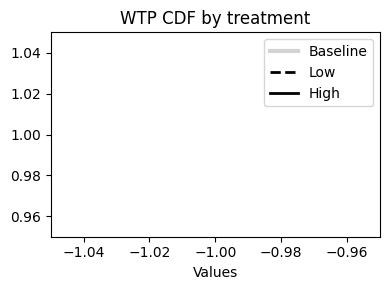

Trad_wtp_strict_neg_ES_wtp_strict_pos ES


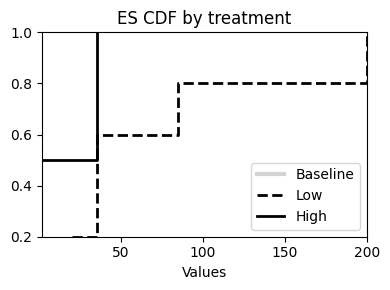

Trad_wtp_strict_neg_ES_wtp_strict_pos Trad


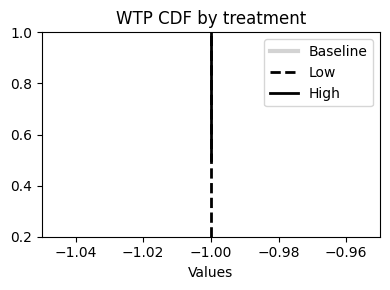

Trad_wtp_zero_ES_wtp_strict_neg ES


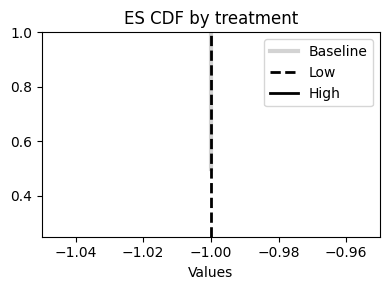

Trad_wtp_zero_ES_wtp_strict_neg Trad


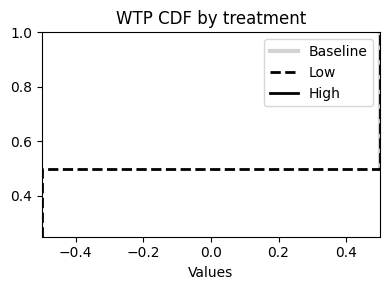

Trad_wtp_zero_ES_wtp_zero ES


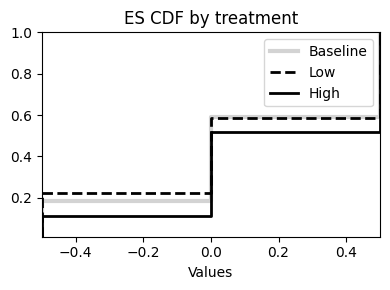

Trad_wtp_zero_ES_wtp_zero Trad


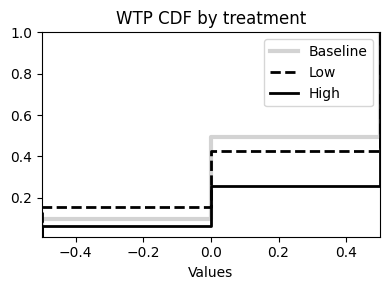

Trad_wtp_zero_ES_wtp_strict_pos ES


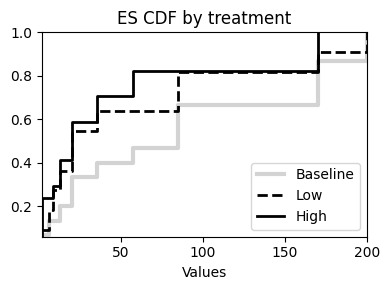

Trad_wtp_zero_ES_wtp_strict_pos Trad


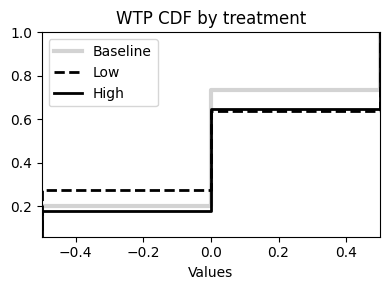

Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_pos ES


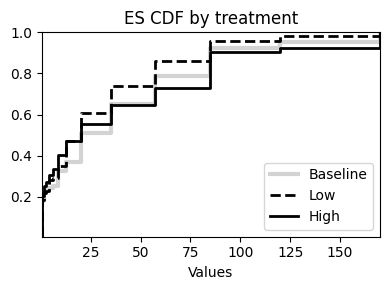

Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_pos Trad


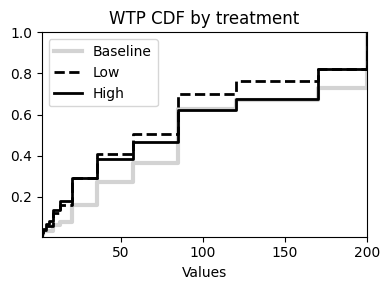

Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg ES


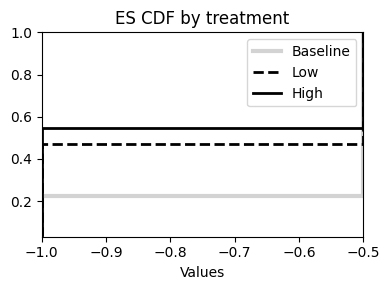

Trad_wtp_strict_pos_ES_wtp_less_than_Trad_and_neg Trad


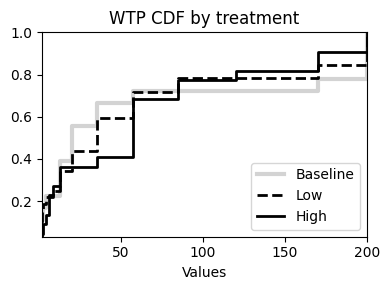

Trad_wtp_strict_pos_ES_wtp_equal_0 ES


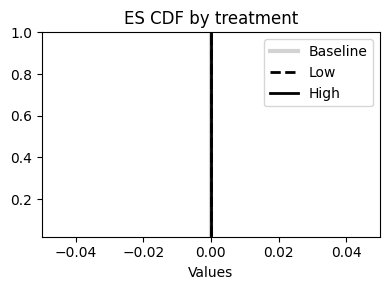

Trad_wtp_strict_pos_ES_wtp_equal_0 Trad


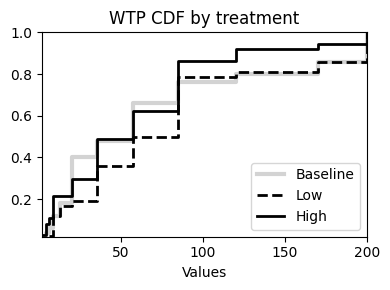

Trad_wtp_strict_pos_ES_wtp_equal_Trad ES


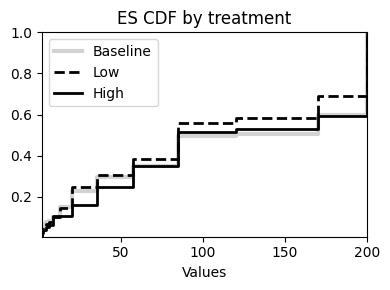

Trad_wtp_strict_pos_ES_wtp_equal_Trad Trad


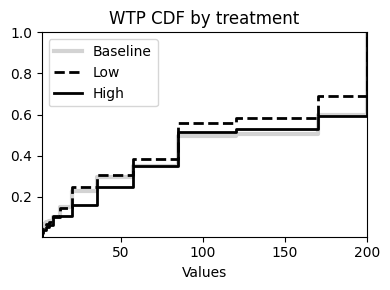

Trad_wtp_strict_pos_ES_wtp_greater_than_Trad ES


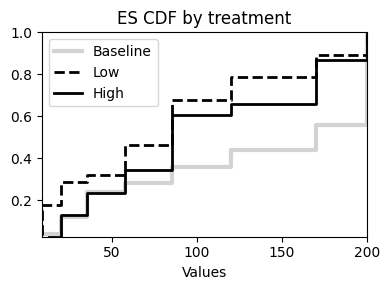

Trad_wtp_strict_pos_ES_wtp_greater_than_Trad Trad


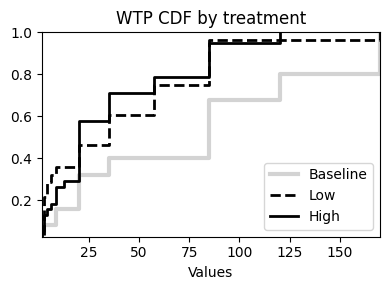

In [35]:

def plot_and_save_cdf_by_treatment(data, treatment_column, WTP_type, filename):
    # Get unique treatment values
    treatments = ['middle', 'low', 'high']
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4,3))
    
    # Loop through unique treatments and plot separate CDF for each
    for treatment in treatments:
        treatment_data = data[data[treatment_column] == treatment]
        sorted_data = np.sort(treatment_data[f'{WTP_type}_wtp_point'])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

        # Set labels based on treatment
        if treatment == 'middle':
            label = 'Baseline'
            color = 'lightgray'
            linestyle = '-'
            linewidth = 3
        elif treatment == 'low':
            label = 'Low'
            color = 'black'
            linestyle = '--'
            linewidth = 2
        elif treatment == 'high':
            label = 'High'
            color = 'black'
            linestyle = '-'
            linewidth = 2
        
        ax.step(sorted_data, cdf, where='post', label=label, color=color, linestyle=linestyle, linewidth=linewidth)

    # Set title based on WTP_type
    if WTP_type == 'ES':
        ax.set_title('ES CDF by treatment')
    elif WTP_type == 'Trad':
        ax.set_title('WTP CDF by treatment')

    # Add labels and legend
    ax.set_xlabel('Values')
    ax.legend()
    ax.margins(x=0,y=0)

    plt.tight_layout()

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'{filename}.png')
    plt.savefig(file_path)


    # Display the plot (optional)
    plt.show()


for WTP_type in ['ES', 'Trad']:
    plot_and_save_cdf_by_treatment(data, 'treatment',WTP_type, f'CDF_by_treatment_{WTP_type}')


list_of_types = []
for WTP_type in ['strict_neg', 'zero']:
    for ES_type in ['strict_neg', 'zero', 'strict_pos']:
        myString = 'Trad_wtp_' + WTP_type +'_ES_wtp_'+ES_type
        list_of_types.append(myString)

for ES_type in ['less_than_Trad_and_pos', 'less_than_Trad_and_neg', 'equal_0', 'equal_Trad', 'greater_than_Trad']:
    myString = 'Trad_wtp_strict_pos_ES_wtp_'+ES_type
    list_of_types.append(myString)

for el in list_of_types:
    for WTP_type in ['ES', 'Trad']:
        print(el, WTP_type)
        plot_and_save_cdf_by_treatment(data[data[el]==1], 'treatment',WTP_type, f'CDF_by_treatment_{el}_{WTP_type}')






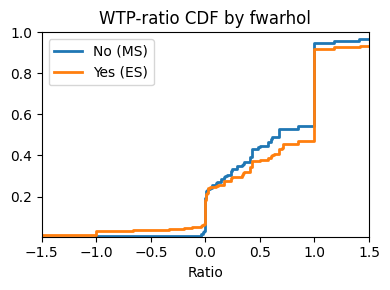

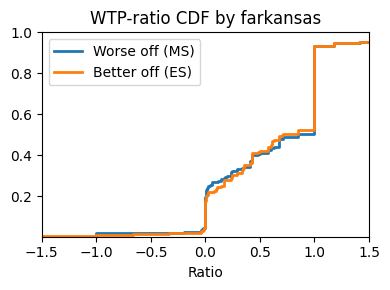

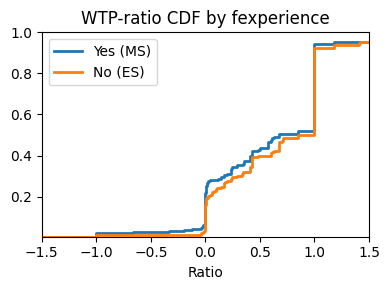

In [69]:

labels_unincentivized = {
    'warhol': [('No', 'No (MS)'), ('Yes', 'Yes (ES)')],
    'arkansas': [('Worse off', 'Worse off (MS)'), ('Better off', 'Better off (ES)')],
    'experience': [('Yes', 'Yes (MS)'), ('No', 'No (ES)')],
}


def plot_and_save_cdf_by_unincentivized_answer(data, question, filename):
    # Get unique treatment values
    answers = labels_unincentivized[question]
    
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(4,3))
    
    # Loop through unique treatments and plot separate CDF for each
    for answer in answers:

        treatment_data = data[data[question] == answer[0]]
        sorted_data = np.sort(treatment_data['wtp_ratio'])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

        
        linestyle = '-'
        linewidth = 2
        
        label=answer[1]
        ax.step(sorted_data, cdf, where='post', label=label, linestyle=linestyle, linewidth=linewidth)
        ax.set_xlim(-1.5, 1.5)
    # Set title based on WTP_type
    # if WTP_type == 'ES':
    #     ax.set_title('ES CDF by treatment')
    # elif WTP_type == 'Trad':
    #     ax.set_title('WTP CDF by treatment')

    ax.set_title(f'WTP-ratio CDF by {question}')

    # Add labels and legend
    ax.set_xlabel('Ratio')
    ax.legend()
    ax.margins(x=0,y=0)

    plt.tight_layout()

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'{filename}.png')
    plt.savefig(file_path)


    # Display the plot (optional)
    plt.show()


cond1 = data['Trad_wtp_point'] > 0
codn2 = data['treatment']=='middle'
for question in labels_unincentivized.keys():
    plot_and_save_cdf_by_unincentivized_answer(data[cond1 & cond2], question, f'wtp-ratio_cdf_{question}')





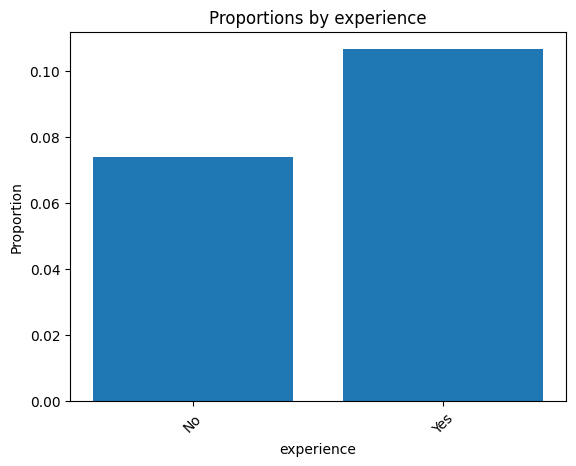

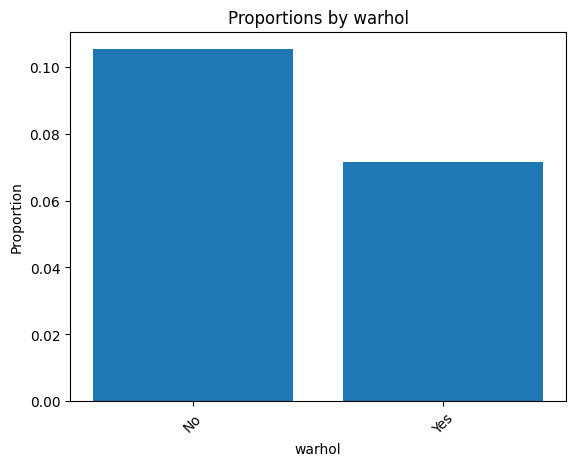

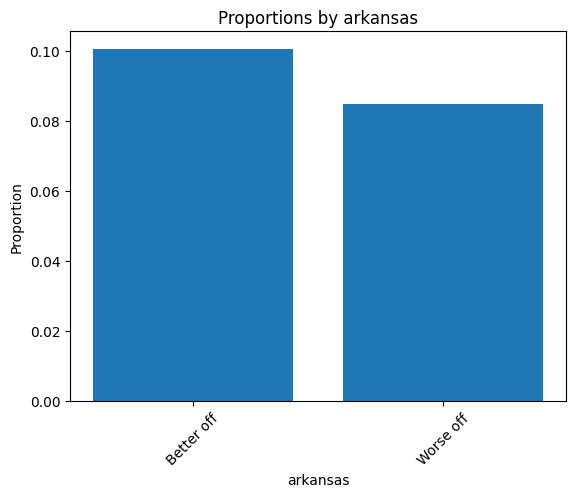

/var/folders/6j/s1yqxb392j11117mvgndr8c40000gn/T/ipykernel_22281/3417764216.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_between = clean_data[cond1 & cond2]


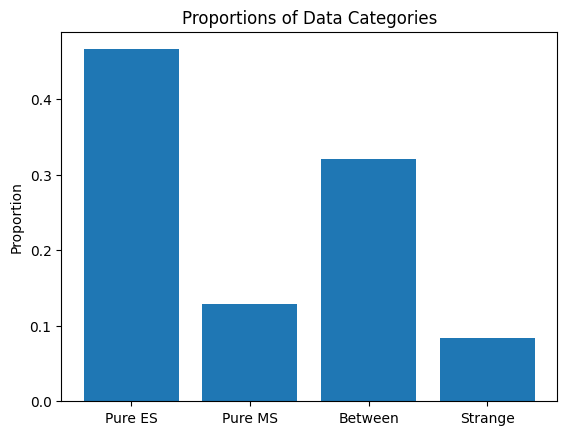

In [32]:

def process_and_plot_proportions(data, columnX, net_noise,filename):
    grouped_data = data.groupby(columnX)
    
    proportions = []

    for group_name, group_data in grouped_data:
        cond1 = group_data['ES_wtp_point'] == 0 
        cond2 = group_data['Trad_wtp_point'] > 0

        pure_MS = group_data[cond1 & cond2]
        pure_MS_prop = len(pure_MS) / len(group_data)

        cond1 = group_data['ES_wtp_point'] > 0 
        cond2 = group_data['Trad_wtp_point'] == 0

        noise = group_data[cond1 & cond2]
        noise_prop = len(noise) / len(group_data)

        if net_noise:
            net_noise_value = pure_MS_prop - noise_prop
        else: 
            net_noise_value = pure_MS_prop
        
        proportions.append(net_noise_value)

    # Plot the proportions as a bar chart
    plt.bar(grouped_data.groups.keys(), proportions)
    plt.xlabel(columnX)
    plt.ylabel('Proportion' if net_noise else 'Pure MS Proportion')
    plt.title(f'Proportions by {columnX}')
    plt.xticks(rotation=45)

    # Save the figure in the current working directory
    plt.savefig(f'proportions_by_{columnX}_{filename}.png')
    # Show the plot
    plt.show()

def process_data_and_save_plot(data, filename):
    cond1 = data['ES_wtp_point'] >= 0 
    cond2 = data['Trad_wtp_point'] > 0
    clean_data = data[cond1 & cond2] 
      
    pure_ES = sum(clean_data['ES_wtp_point'] == clean_data['Trad_wtp_point']) / len(clean_data)
    pure_MS = sum(clean_data['ES_wtp_point'] == 0) / len(clean_data)

    cond1 = data['ES_wtp_point'] > 0 
    cond2 = data['Trad_wtp_point'] > data['ES_wtp_point']

    data_between = clean_data[cond1 & cond2] 

    between = len(data_between) / len(clean_data)
    strange = 1 - pure_ES - pure_MS - between

    # Plot the results as a bar chart
    labels = ['Pure ES', 'Pure MS', 'Between', 'Strange']
    proportions = [pure_ES, pure_MS, between, strange]

    plt.bar(labels, proportions)
    plt.ylabel('Proportion')
    plt.title('Proportions of Data Categories')

    # Save the figure in the current working directory
    plt.savefig(f'proportions_{filename}.png')

    # Display the plot (optional)
    plt.show()

process_and_plot_proportions(data, 'experience', net_noise=True, filename='MS')
process_and_plot_proportions(data, 'warhol', net_noise=True, filename='MS')
process_and_plot_proportions(data, 'arkansas', net_noise=True, filename='MS')
process_data_and_save_plot(data, 'welfare_notions_proportions')


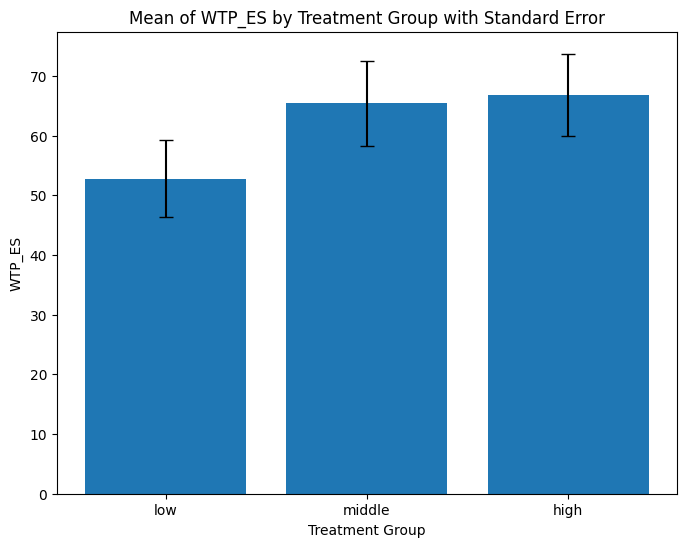

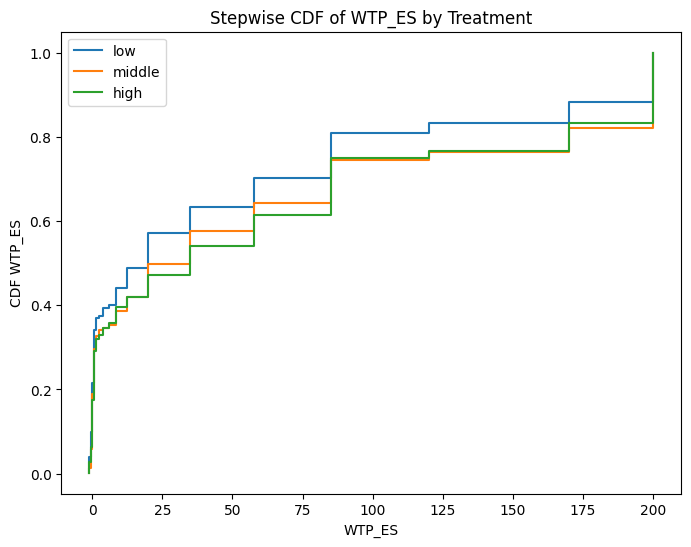

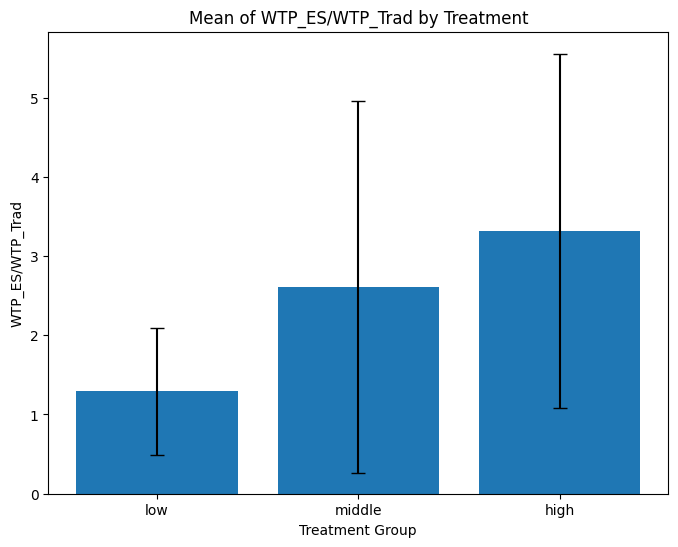

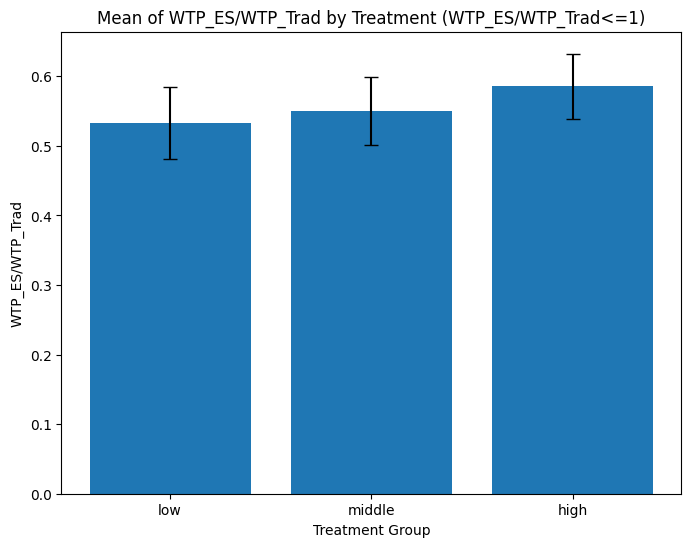

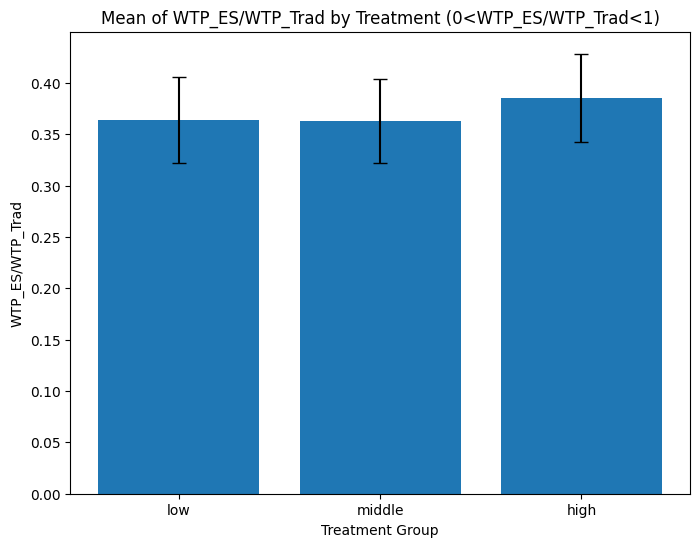

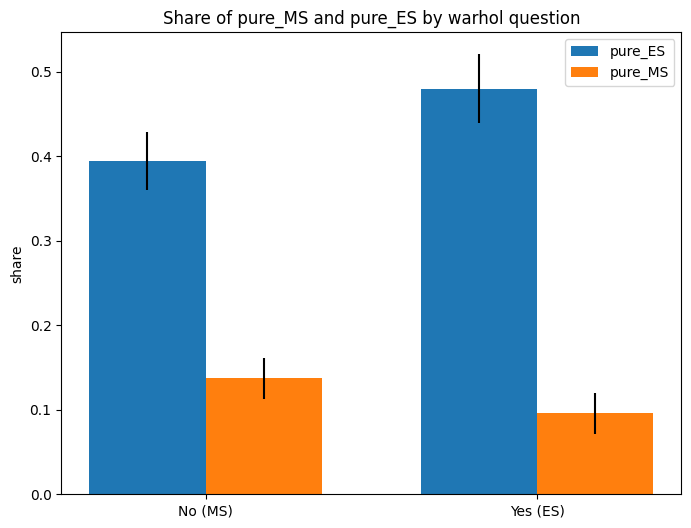

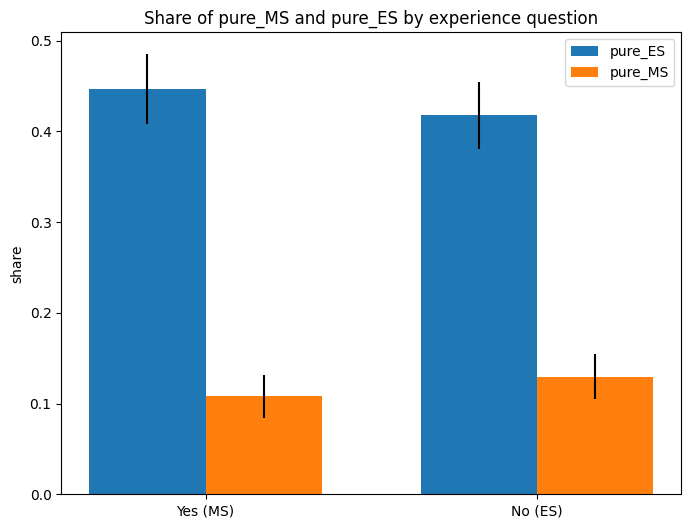

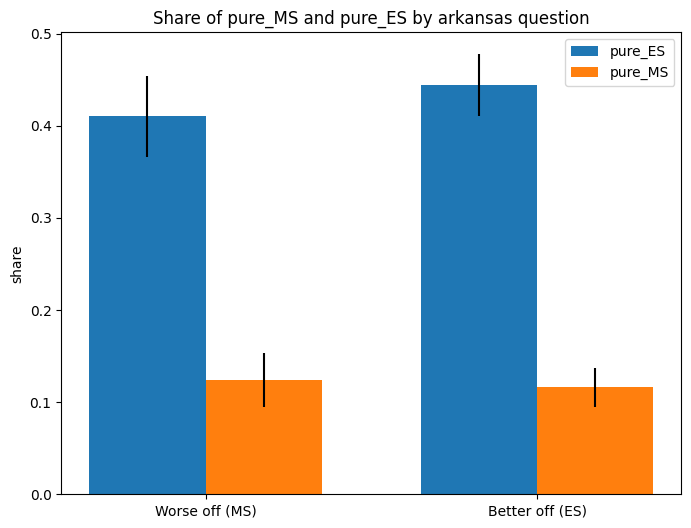

In [33]:
CI_CONSTANT = 1.959964

def create_and_save_chart(data, subfolder_path, column, title, filename, x_label, y_label, chart_type='bar', conditions=None):
    if conditions is not None:
        clean_data = data[conditions]
    else:
        clean_data = data

    treatments = ['low', 'middle', 'high']
    
    # Create a figure and axis for the subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if chart_type == 'bar':
        # Calculate the mean and standard error of 'X' by treatment group
        grouped_data = clean_data.groupby('treatment')[column]
        mean_values = grouped_data.mean()
        std_values = grouped_data.std()
        std_error_values = std_values / np.sqrt(grouped_data.count())
        
        # Create a bar chart with error bars on the subplot 'ax'
        ax.bar(treatments, [mean_values[treatments[0]],mean_values[treatments[1]],mean_values[treatments[2]]], yerr=[CI_CONSTANT*std_error_values[treatments[0]],CI_CONSTANT*std_error_values[treatments[1]],CI_CONSTANT*std_error_values[treatments[2]]], capsize=5)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
    elif chart_type == 'cdf':
        # Loop through unique treatments and plot separate CDF for each
        for treatment in treatments:
            treatment_data = clean_data[clean_data['treatment'] == treatment]
            sorted_data = np.sort(treatment_data[column])
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            ax.step(sorted_data, cdf, where='post', label=f'{treatment}')
        
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.legend()
    
    ax.set_title(title)

    # Save the plot in the subfolder
    file_path = os.path.join(subfolder_path, filename)
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Figure 1
create_and_save_chart(data, subfolder_path, 'ES_wtp_point', 'Mean of WTP_ES by Treatment Group with Standard Error',
                      'fig_1.png', 'Treatment Group', 'WTP_ES', chart_type='bar',
                      conditions=data['Trad_wtp_point'] > 0)

# Figure 2
create_and_save_chart(data, subfolder_path, 'ES_wtp_point', 'Stepwise CDF of WTP_ES by Treatment',
                      'fig_2.png', 'WTP_ES', 'CDF WTP_ES', chart_type='cdf',
                      conditions=data['Trad_wtp_point'] > 0)  

# Figure 3 w/o cutting
create_and_save_chart(data, subfolder_path, 'share_ES', 'Mean of WTP_ES/WTP_Trad by Treatment',
                      'fig_3_wo_cutting.png', 'Treatment Group', 'WTP_ES/WTP_Trad', chart_type='bar',
                      conditions=data['Trad_wtp_point'] > 0)  

# Figure 3 w/ cutting 
cond1 = data['Trad_wtp_point'] > 0
# cond2 = data['share_ES'] > 0
cond3 = data['share_ES'] <= 1
create_and_save_chart(data, subfolder_path, 'share_ES', 'Mean of WTP_ES/WTP_Trad by Treatment (WTP_ES/WTP_Trad<=1)',
                      'fig_3_w_cutting.png', 'Treatment Group', 'WTP_ES/WTP_Trad', chart_type='bar',
                      conditions=cond1 & cond3)  

# Figure 4 
cond1 = data['Trad_wtp_point'] > 0
cond2 = data['share_ES'] > 0
cond3 = data['share_ES'] < 1
create_and_save_chart(data, subfolder_path, 'share_ES', 'Mean of WTP_ES/WTP_Trad by Treatment (0<WTP_ES/WTP_Trad<1)',
                      'fig_4.png', 'Treatment Group', 'WTP_ES/WTP_Trad', chart_type='bar',
                      conditions=cond1 & cond2 & cond3)  


# labels_unincentivized = {
#     'warhol': [('No', 'No (MS)'), ('Yes', 'Yes (ES)')],
#     'arkansas': [('Worse off', 'Worse off (MS)'), ('Better off', 'Better off (ES)')],
#     'experience': [('Yes', 'Yes (MS)'), ('No', 'No (ES)')],
# }

def create_and_save_chart(data, subfolder_path, question, columns, title, filename, y_label, conditions=None):
    if conditions is not None:
        clean_data = data[conditions]
    else:
        clean_data = data

    treatments = [labels_unincentivized[question][el][0] for el in range(len(labels_unincentivized[question]))]
    labels = [labels_unincentivized[question][el][1] for el in range(len(labels_unincentivized[question]))]

    # Create a figure and axis for the subplot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Calculate the mean and standard error of columns by treatment group
    grouped_data = clean_data.groupby(question)[columns]
    mean_values = grouped_data.mean()
    std_values = grouped_data.std()
    std_error_values = std_values / np.sqrt(grouped_data.count())

    x = np.arange(len(treatments))
    width = 0.35

    for i in range(len(columns)):
        ax.bar(x + i * width, mean_values[columns[i]], width, yerr=CI_CONSTANT*std_error_values[columns[i]], label=columns[i])

    ax.set_xticks(x + (width * (len(columns) - 1)) / 2)
    ax.set_xticklabels(labels)
    ax.set_ylabel(y_label)
    ax.legend()

    ax.set_title(title)

    # Save the plot in the subfolder
    file_path = os.path.join(subfolder_path, filename)
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Figures 5
columns = ['pure_ES', 'pure_MS']
create_and_save_chart(data, subfolder_path, 'warhol', columns, 'Share of pure_MS and pure_ES by warhol question', 'fig5_warhol_share.png', 'share', conditions=data['Trad_wtp_point'] > 0)
create_and_save_chart(data, subfolder_path, 'experience', columns, 'Share of pure_MS and pure_ES by experience question', 'fig5_experience_share.png', 'share', conditions=data['Trad_wtp_point'] > 0)
create_and_save_chart(data, subfolder_path, 'arkansas', columns, 'Share of pure_MS and pure_ES by arkansas question', 'fig5_arkansas_share.png', 'share', conditions=data['Trad_wtp_point'] > 0)